In [1]:
import cenpy
import osmnx
import contextily
import networkx as nx
import pandas as pd
import pickle
import geopandas
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

In [3]:
%load_ext autoreload
%autoreload 2
import dem_functions as df
import bikeability_functions as bf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
plt.style.use('seaborn')

C:\Users\kyan\AppData\Local\Temp\ipykernel_3900\240305066.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Geographic equity

In [86]:
def origin_curves(G,betas=np.linspace(0.01,10,200)):
    curves = {}
    # calculate single-origin bikeability from each tract
    for u in G.nodes:
        bike_curves = bf.compute_bikeability_curves(G,[u],dest='all')
        # weighted by euclidean distance
        network_curve = bf.network_wide_bikeability_curve(betas, bike_curves)
        curves[u] = network_curve
        
    return curves

In [148]:
def calc_elbows(curves):
    elbow_prox = {}

    for u in curves:
        user_dict = curves[u]
        x = np.array(list(user_dict.values()))[:,1]
        y = np.array(list(user_dict.values()))[:,2]

        kneedle = KneeLocator(x, y, S=1.0, curve='convex', direction='decreasing')
        dist =((kneedle.elbow-1)**2 + kneedle.elbow_y**2)**0.5

        elbow_prox[u] = 1/dist
        
    return elbow_prox

In [58]:
def calc_theil(elbow_prox):
    vals = list(elbow_prox.values())
    avg = np.mean(vals)
    theil = np.mean((vals/avg)*np.log(vals/avg))
    return theil

In [199]:
def calc_gini(elbow_prox):
    vals_sorted = sorted(list(elbow_prox.values()))
    N = len(vals_sorted)
    
    F = np.linspace(1,N,N)/N
    Q = np.cumsum(vals_sorted)/np.sum(vals_sorted)
    gini = (2/(N-1))*np.sum(abs(F-Q))
    return gini

In [ ]:
G_SF = bf.load_graph('data/V2_SF_coarse_graph_cluster')
curves_SF = origin_curves(G_SF)

In [201]:
elbows_SF = calc_elbows(curves)
calc_gini(elbows_SF)

0.17342772046407542

In [240]:
np.std(list(elbows_SF.values()))

1.2604297345935258

In [ ]:
G_Detroit = bf.load_graph('data/V2_Detroit_coarse_graph_cluster') 
curves_Detroit = origin_curves(G_Detroit)

In [202]:
elbows_Detroit = calc_elbows(curves_Detroit)
calc_gini(elbows_Detroit)

0.07008777340197159

In [242]:
np.std(list(elbows_Detroit.values()))

0.30247243881170366

In [ ]:
G_Philly = bf.load_graph('data/V2_Philly_coarse_graph_cluster') 
curves_Philly = origin_curves(G_Philly)

In [203]:
elbows_Philly = calc_elbows(curves_Philly)
calc_gini(elbows_Philly)

0.08204765771758181

In [243]:
np.std(list(elbows_Philly.values()))

0.4654154683231754

In [236]:
def plot_bikeabilities(place,elbows):
    acs_vars = {'B02001_001E':'total_pop'}
    dem = df.get_dem(place,acs_vars)
    dem['elbow_dist'] = dem['tract'].apply(lambda x: elbows[x] if x in elbows else np.NaN)
    dem.plot('elbow_dist',cmap='plasma',vmin=1,vmax=8,legend=True)
    plt.xticks([])
    plt.yticks([])

Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


C:\Users\kyan3\Documents\Thesis\dem_functions.py:8: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



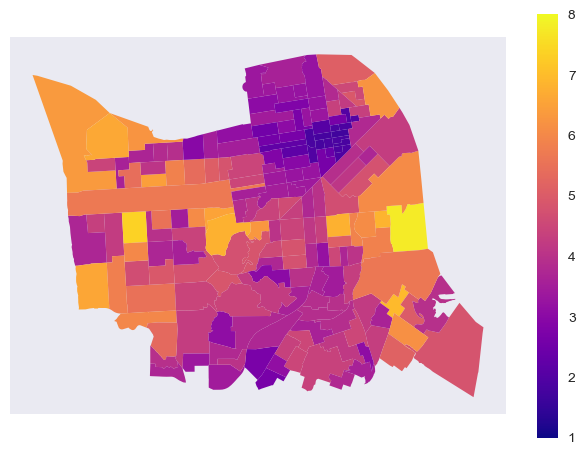

In [229]:
plot_bikeabilities('San Francisco,CA',elbows_SF)
plt.savefig('figures/geographic_eq_SF.png',dpi=300,facecolor='white')

Matched: Detroit,MI to Detroit city within layer Incorporated Places


C:\Users\kyan3\Documents\Thesis\dem_functions.py:8: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



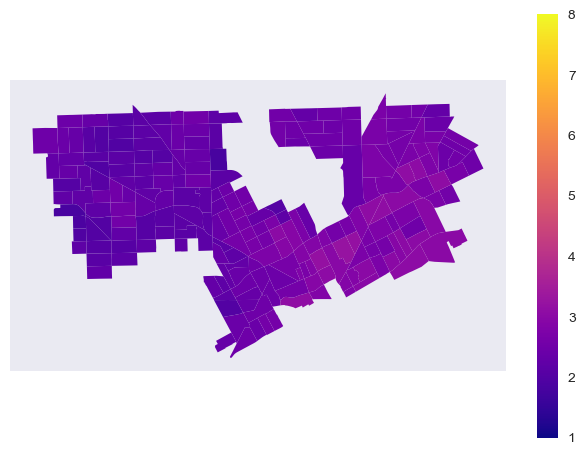

In [230]:
plot_bikeabilities('Detroit,MI',elbows_Detroit)
plt.savefig('figures/geographic_eq_Detroit.png',dpi=300,facecolor='white')

Matched: Philadelphia,PA to Philadelphia city within layer Incorporated Places


C:\Users\kyan3\Documents\Thesis\dem_functions.py:8: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



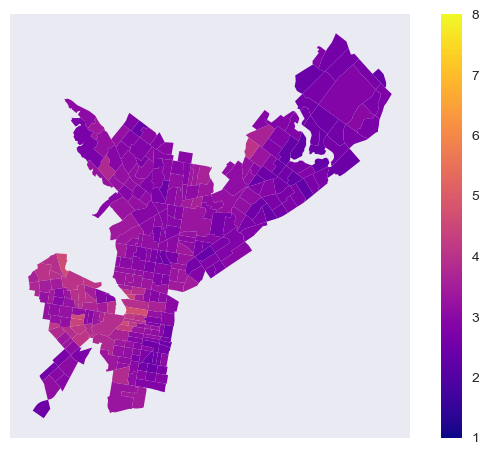

In [237]:
plot_bikeabilities('Philadelphia,PA',elbows_Philly)
plt.savefig('figures/geographic_eq_Philly.png',dpi=300,facecolor='white')

# Demographic Equity

In [7]:
acs_vars = {'B02001_001E':'total_pop','B02001_002E':'total_pop_white',
            'B19013_001E':'median_hh_income','B06012_002E':'below_poverty',
            'B08014_001E':'total_workers','B08014_002E':'zero_vehicles'}

In [8]:
def dem_features(dem):
    dem['frac_pop_nonwhite'] = (dem['total_pop']-dem['total_pop_white'])/dem['total_pop']
    dem['frac_below_poverty'] = dem['below_poverty']/dem['total_pop']
    dem['frac_no_car'] = dem['zero_vehicles']/dem['total_workers']

In [9]:
def quint_curves(G,quant_of_int,var,betas=np.linspace(0.01,10,200)):
    var_low = bf.compute_bikeability_curves(G,quant_of_int[var][0])
    var_high = bf.compute_bikeability_curves(G,quant_of_int[var][1])
    
    curve_1=bf.network_wide_bikeability_curve(betas, var_low)
    curve_2=bf.network_wide_bikeability_curve(betas, var_high)
    
    return curve_1,curve_2

In [10]:
def compare_curves(curve_low,curve_high,ax,variable):
    line1, =ax.plot(np.array([data[1] for _,data in curve_low.items()]),
                     np.array([data[2] for _,data in curve_low.items()]),
                    linewidth=1,color='red',alpha=0.5,label='Lowest 20%')
    ax.scatter(np.array([data[1] for _,data in curve_low.items()]),
                     np.array([data[2] for _,data in curve_low.items()]),s=18,c='red')
    
    line2, =ax.plot(np.array([data[1] for _,data in curve_high.items()]),
                     np.array([data[2] for _,data in curve_high.items()]),
                    linewidth=1,color='blue',alpha=0.5,label='Highest 20%')
    ax.scatter(np.array([data[1] for _,data in curve_high.items()]),
                     np.array([data[2] for _,data in curve_high.items()]),s=18,c='blue')
    
    #ax.set_xlim([0.975,1.375])
    #ax.set_ylim([0.1,0.7])
    
    #ax.set_xlim([0.975,1.2])
    #ax.set_ylim([0.2,0.6])
    
    ax.set_xlim([0.975,1.2])
    ax.set_ylim([0.25,0.65])
    
    ax.set_xlabel('Normalized Distance',fontsize=12)
    ax.set_ylabel('Normalized Discomfort',fontsize=12)
    ax.set_title(variable,fontsize=14,fontweight='semibold')
    ax.legend(handles=[line2,line1],frameon=True,facecolor='white')

## San Francisco

In [11]:
G_SF = bf.load_graph('data/V2_SF_coarse_graph_cluster')

In [12]:
dem_SF = df.get_dem('San Francisco,CA',acs_vars)

Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


C:\Users\kyan\Documents\bikeability\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


In [13]:
dem_features(dem_SF)

In [14]:
keys = ['frac_pop_nonwhite','frac_below_poverty','median_hh_income','frac_no_car']
quant_of_int = df.all_quants(keys,dem_SF)

In [15]:
nonwhite_low,nonwhite_high = quint_curves(G_SF,quant_of_int,'frac_pop_nonwhite')

In [16]:
poverty_low,poverty_high = quint_curves(G_SF,quant_of_int,'frac_below_poverty')

In [17]:
income_low,income_high = quint_curves(G_SF,quant_of_int,'median_hh_income')

In [18]:
carless_low,carless_high = quint_curves(G_SF,quant_of_int,'frac_no_car')

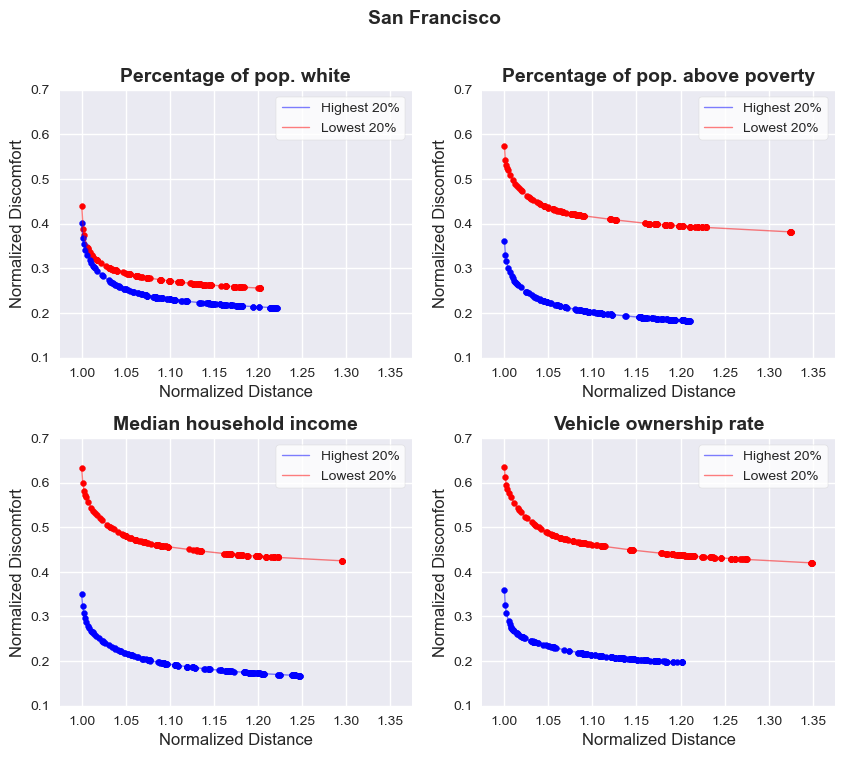

In [157]:
fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(10,8))
compare_curves(nonwhite_high,nonwhite_low,axs[0][0],'Percentage of pop. white')
compare_curves(poverty_high,poverty_low,axs[0][1],'Percentage of pop. above poverty')
compare_curves(income_low,income_high,axs[1][0],'Median household income')
compare_curves(carless_high,carless_low,axs[1][1],'Vehicle ownership rate')
fig.subplots_adjust(hspace=0.3)
fig.suptitle('San Francisco',fontweight='semibold',fontsize=14)
fig.savefig('figures/SF_dem_equity.png',facecolor='white',dpi=300)

In [127]:
print('SAN FRANCISCO')
print('Nonwhite low, high: ',bf.calc_elbow(nonwhite_low),bf.calc_elbow(nonwhite_high))
print('Poverty low, high: ',bf.calc_elbow(poverty_low),bf.calc_elbow(poverty_high))
print('Income low, high: ',bf.calc_elbow(income_low),bf.calc_elbow(income_high))
print('Carless low, high: ',bf.calc_elbow(carless_low),bf.calc_elbow(carless_high))

SAN FRANCISCO
Nonwhite low, high:  3.808702606603467 3.3671723281804113
Poverty low, high:  4.283295782988179 2.31807107331084
Income low, high:  2.102801531520273 4.505874684237225
Carless low, high:  4.109592625671119 2.081167457479661


In [129]:
print('BIKEABILITY QUINTILE RATIO')
print('Nonwhite: ',bf.calc_elbow(nonwhite_low)/bf.calc_elbow(nonwhite_high))
print('Poverty: ',bf.calc_elbow(poverty_low)/bf.calc_elbow(poverty_high))
print('Income: ',bf.calc_elbow(income_high)/bf.calc_elbow(income_low))
print('Carless: ',bf.calc_elbow(carless_low)/bf.calc_elbow(carless_high))

BIKEABILITY QUINTILE RATIO
Nonwhite:  1.1311279125002949
Poverty:  1.8477844930226668
Income:  2.1427959874936886
Carless:  1.9746573544100696


## Philadelphia

In [19]:
G_Philly = bf.load_graph('data/V2_Philly_coarse_graph_cluster')
dem_Philly = df.get_dem('Philadelphia,PA',acs_vars)

Matched: Philadelphia,PA to Philadelphia city within layer Incorporated Places


C:\Users\kyan\Documents\bikeability\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


In [20]:
# take out census tracts that aren't part of network's giant component
dem_Philly = dem_Philly[dem_Philly['tract'].isin(list(G_Philly.nodes()))]

In [21]:
dem_features(dem_Philly)

In [22]:
keys = ['frac_pop_nonwhite','frac_below_poverty','median_hh_income','frac_no_car']
quant_of_int_Philly = df.all_quants(keys,dem_Philly)

In [94]:
nonwhite_low_Philly,nonwhite_high_Philly = quint_curves(G_Philly,quant_of_int_Philly,'frac_pop_nonwhite')

In [95]:
poverty_low_Philly,poverty_high_Philly = quint_curves(G_Philly,quant_of_int_Philly,'frac_below_poverty')

In [96]:
income_low_Philly,income_high_Philly = quint_curves(G_Philly,quant_of_int_Philly,'median_hh_income')

In [23]:
carless_low_Philly,carless_high_Philly = quint_curves(G_Philly,quant_of_int_Philly,'frac_no_car')

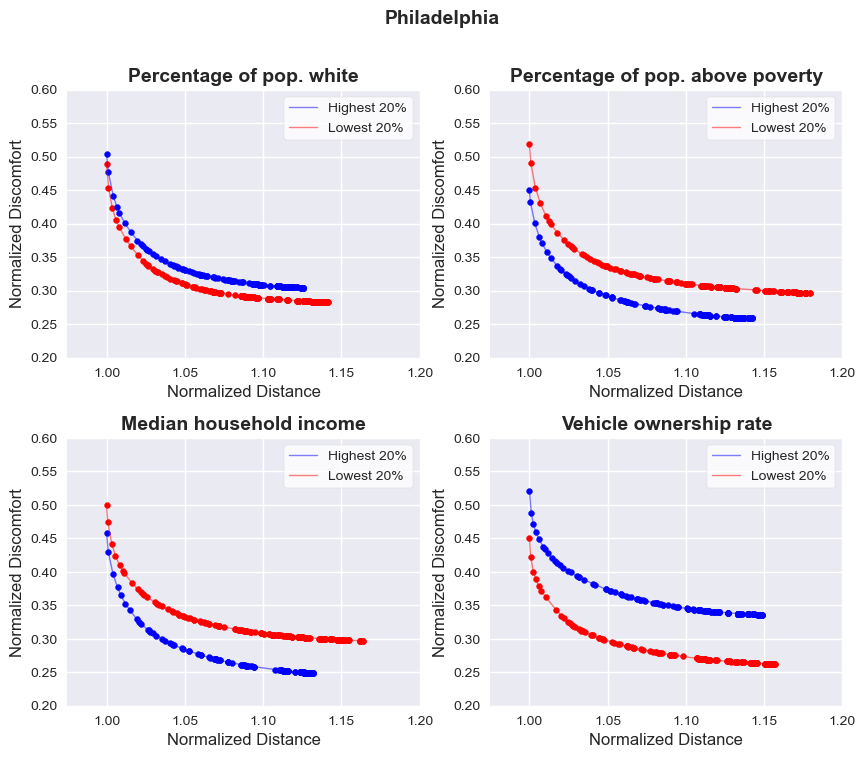

In [155]:
fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(10,8))
compare_curves(nonwhite_high_Philly,nonwhite_low_Philly,axs[0][0],'Percentage of pop. white')
compare_curves(poverty_high_Philly,poverty_low_Philly,axs[0][1],'Percentage of pop. above poverty')
compare_curves(income_low_Philly,income_high_Philly,axs[1][0],'Median household income')
compare_curves(carless_high_Philly,carless_low_Philly,axs[1][1],'Vehicle ownership rate')
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Philadelphia',fontweight='semibold',fontsize=14)
fig.savefig('figures/Philly_dem_equity.png',facecolor='white',dpi=300)

In [126]:
print('PHILADELPHIA')
print('Nonwhite low, high: ',bf.calc_elbow(nonwhite_low_Philly),bf.calc_elbow(nonwhite_high_Philly))
print('Poverty low, high: ',bf.calc_elbow(poverty_low_Philly),bf.calc_elbow(poverty_high_Philly))
print('Income low, high: ',bf.calc_elbow(income_low_Philly),bf.calc_elbow(income_high_Philly))
print('Carless low, high: ',bf.calc_elbow(carless_low_Philly),bf.calc_elbow(carless_high_Philly))

PHILADELPHIA
Nonwhite low, high:  2.8149556882871263 3.020088989699843
Poverty low, high:  3.2073954417643504 2.8582957448522577
Income low, high:  2.8561081422162364 3.2315332468152014
Carless low, high:  2.5419160941894856 3.184403139321498


In [130]:
print('BIKEABILITY QUINTILE RATIO')
print('Nonwhite: ',bf.calc_elbow(nonwhite_low_Philly)/bf.calc_elbow(nonwhite_high_Philly))
print('Poverty: ',bf.calc_elbow(poverty_low_Philly)/bf.calc_elbow(poverty_high_Philly))
print('Income: ',bf.calc_elbow(income_high_Philly)/bf.calc_elbow(income_low_Philly))
print('Carless: ',bf.calc_elbow(carless_low_Philly)/bf.calc_elbow(carless_high_Philly))

BIKEABILITY QUINTILE RATIO
Nonwhite:  0.9320770672280408
Poverty:  1.1221356108935947
Income:  1.1314463899492435
Carless:  0.7982394134717166


## Detroit

In [24]:
G_Detroit = bf.load_graph('data/V2_Detroit_coarse_graph_cluster')
dem_Detroit = df.get_dem('Detroit,MI',acs_vars)

Matched: Detroit,MI to Detroit city within layer Incorporated Places


C:\Users\kyan\Documents\bikeability\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


In [25]:
# take out census tracts that aren't part of network's giant component
dem_Detroit = dem_Detroit[dem_Detroit['tract'].isin(list(G_Detroit.nodes()))]

In [26]:
dem_features(dem_Detroit)

In [27]:
keys = ['frac_pop_nonwhite','frac_below_poverty','median_hh_income','frac_no_car']
quant_of_int_Detroit = df.all_quants(keys,dem_Detroit)

In [108]:
nonwhite_low_Detroit,nonwhite_high_Detroit = quint_curves(G_Detroit,quant_of_int_Detroit,'frac_pop_nonwhite')

In [109]:
poverty_low_Detroit,poverty_high_Detroit = quint_curves(G_Detroit,quant_of_int_Detroit,'frac_below_poverty')

In [110]:
income_low_Detroit,income_high_Detroit = quint_curves(G_Detroit,quant_of_int_Detroit,'median_hh_income')

In [28]:
carless_low_Detroit,carless_high_Detroit = quint_curves(G_Detroit,quant_of_int_Detroit,'frac_no_car')

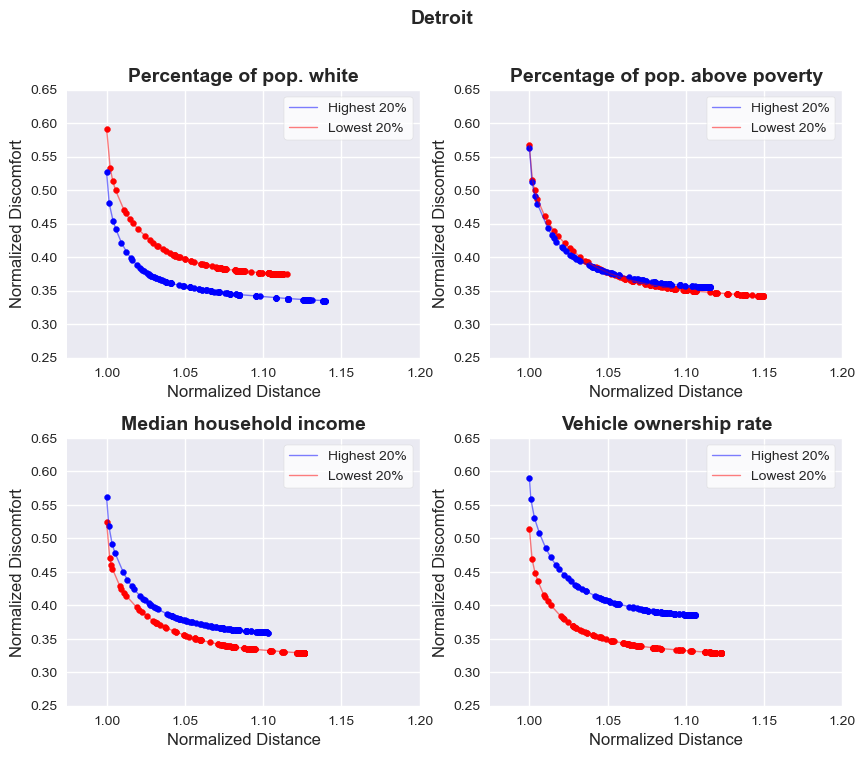

In [159]:
fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(10,8))
compare_curves(nonwhite_high_Detroit,nonwhite_low_Detroit,axs[0][0],'Percentage of pop. white')
compare_curves(poverty_high_Detroit,poverty_low_Detroit,axs[0][1],'Percentage of pop. above poverty')
compare_curves(income_low_Detroit,income_high_Detroit,axs[1][0],'Median household income')
compare_curves(carless_high_Detroit,carless_low_Detroit,axs[1][1],'Vehicle ownership rate')
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Detroit',fontweight='semibold',fontsize=14)
fig.savefig('figures/Detroit_dem_equity.png',facecolor='white',dpi=300)

In [128]:
print('DETROIT')
print('Nonwhite low, high: ',bf.calc_elbow(nonwhite_low_Detroit),bf.calc_elbow(nonwhite_high_Detroit))
print('Poverty low, high: ',bf.calc_elbow(poverty_low_Detroit),bf.calc_elbow(poverty_high_Detroit))
print('Income low, high: ',bf.calc_elbow(income_low_Detroit),bf.calc_elbow(income_high_Detroit))
print('Carless low, high: ',bf.calc_elbow(carless_low_Detroit),bf.calc_elbow(carless_high_Detroit))

DETROIT
Nonwhite low, high:  2.667344385697605 2.344503254538201
Poverty low, high:  2.4733312572155373 2.5331124904110633
Income low, high:  2.656824245927203 2.448855199842331
Carless low, high:  2.29021343744592 2.7024889988184393


In [131]:
print('BIKEABILITY QUINTILE RATIO')
print('Nonwhite: ',bf.calc_elbow(nonwhite_low_Detroit)/bf.calc_elbow(nonwhite_high_Detroit))
print('Poverty: ',bf.calc_elbow(poverty_low_Detroit)/bf.calc_elbow(poverty_high_Detroit))
print('Income: ',bf.calc_elbow(income_high_Detroit)/bf.calc_elbow(income_low_Detroit))
print('Carless: ',bf.calc_elbow(carless_low_Detroit)/bf.calc_elbow(carless_high_Detroit))

BIKEABILITY QUINTILE RATIO
Nonwhite:  1.1377012936682802
Poverty:  0.9764000874726945
Income:  0.9217226933984514
Carless:  0.8474459797790959


## All cities

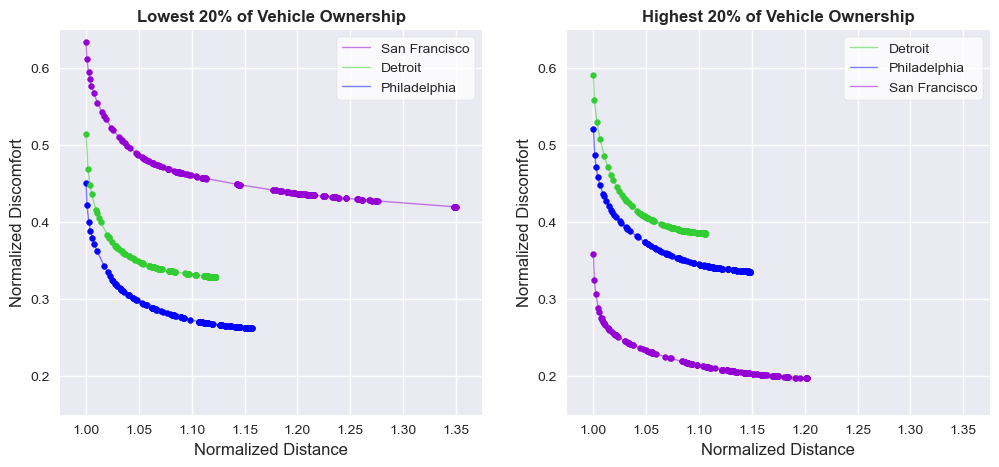

In [29]:
fig,axs=plt.subplots(ncols=2,figsize=(12,5))

line1, =axs[0].plot(np.array([data[1] for _,data in carless_high.items()]),
                     np.array([data[2] for _,data in carless_high.items()]),
                    linewidth=1,color='darkviolet',alpha=0.5,label='San Francisco')
axs[0].scatter(np.array([data[1] for _,data in carless_high.items()]),
                     np.array([data[2] for _,data in carless_high.items()]),s=18,c='darkviolet')

line2, =axs[0].plot(np.array([data[1] for _,data in carless_high_Philly.items()]),
                     np.array([data[2] for _,data in carless_high_Philly.items()]),
                    linewidth=1,color='blue',alpha=0.5,label='Philadelphia')
axs[0].scatter(np.array([data[1] for _,data in carless_high_Philly.items()]),
                     np.array([data[2] for _,data in carless_high_Philly.items()]),s=18,c='blue')

line3, =axs[0].plot(np.array([data[1] for _,data in carless_high_Detroit.items()]),
                     np.array([data[2] for _,data in carless_high_Detroit.items()]),
                    linewidth=1,color='limegreen',alpha=0.5,label='Detroit')
axs[0].scatter(np.array([data[1] for _,data in carless_high_Detroit.items()]),
                     np.array([data[2] for _,data in carless_high_Detroit.items()]),s=18,c='limegreen')

axs[0].set_xlim([0.975,1.375])
axs[0].set_ylim([0.15,0.65])
axs[0].set_xlabel('Normalized Distance',fontsize=12)
axs[0].set_ylabel('Normalized Discomfort',fontsize=12)

axs[0].legend(handles=[line1,line3,line2],frameon=True,facecolor='white')
axs[0].set_title('Lowest 20% of Vehicle Ownership',fontweight='semibold')

line4, =axs[1].plot(np.array([data[1] for _,data in carless_low.items()]),
                     np.array([data[2] for _,data in carless_low.items()]),
                    linewidth=1,color='darkviolet',alpha=0.5,label='San Francisco')
axs[1].scatter(np.array([data[1] for _,data in carless_low.items()]),
                     np.array([data[2] for _,data in carless_low.items()]),s=18,c='darkviolet')

line5, =axs[1].plot(np.array([data[1] for _,data in carless_low_Philly.items()]),
                     np.array([data[2] for _,data in carless_low_Philly.items()]),
                    linewidth=1,color='blue',alpha=0.5,label='Philadelphia')
axs[1].scatter(np.array([data[1] for _,data in carless_low_Philly.items()]),
                     np.array([data[2] for _,data in carless_low_Philly.items()]),s=18,c='blue')

line6, =axs[1].plot(np.array([data[1] for _,data in carless_low_Detroit.items()]),
                     np.array([data[2] for _,data in carless_low_Detroit.items()]),
                    linewidth=1,color='limegreen',alpha=0.5,label='Detroit')
axs[1].scatter(np.array([data[1] for _,data in carless_low_Detroit.items()]),
                     np.array([data[2] for _,data in carless_low_Detroit.items()]),s=18,c='limegreen')

axs[1].set_xlim([0.975,1.375])
axs[1].set_ylim([0.15,0.65])
axs[1].set_xlabel('Normalized Distance',fontsize=12)
axs[1].set_ylabel('Normalized Discomfort',fontsize=12)

axs[1].legend(handles=[line3,line2,line1],frameon=True,facecolor='white')
axs[1].set_title('Highest 20% of Vehicle Ownership',fontweight='semibold')
fig.savefig('figures/car_ownership_eq.png',facecolor='white',dpi=300)